# <font color='blue'>Data Science Academy - Machine Learning</font>

# <font color='blue'>Capítulo 10 - Mini-Projeto - Agrupando Clientes Por Consumo de Energia</font>


O seguinte projeto é foi uma atividade do curso de Machine Learning do Data Science Academy sobre modelos de
Clusterização, mais especificamente sobre o modelo K-Means.

## Descrição da atividade

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

Você deve executar as seguintes tarefas:
    
1- Tratar os valores ausentes nos dados.

2- Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.

3- Encontrar o melhor valor de K para esse conjunto de dados.

4- Criar o modelo K-Means usando o valor de K encontrado no item 3.

5- Criar um Meshgrid para visualização de todos os clusters.

6- Visualizar os centróides.

7- Calcular o Silhoutte Score.

8 - Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Carregando os dados
# fonte: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
dataset = pd.read_csv('./household_power_consumption.txt', delimiter = ';', low_memory = False)

In [23]:
# breve estudo dos dados
    # Data: Data no formato dd/mm/aaaa
    # Time: hora no formato hh:mm:ss
    # Global_active_power: potência ativa média global doméstica por minuto (em quilowatts)
    # Global_reactive_power: potência reativa média global doméstica por minuto (em quilowatts)
    # Voltage: tensão média por minuto (em volts)
    # Global_intensity: intensidade de corrente média global por minuto doméstica (em amperes)
    # Sub_metering_1: submedição de energia nº 1 (em watt-hora de energia ativa)
    # Sub_metering_2: submedição de energia nº 2 (em watt-hora de energia ativa)
    # Sub_metering_3: submedição de energia nº 3 (em watt-hora de energia ativa)
# Date e Time não são colunas relevantes para esta análise, logo devem ser removidas
# grande parte das colunas é to tipo object(string) e devem ser convertidas para o tipo float
print(dataset.dtypes)
# exibição das primeiras linhas
dataset.head()

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# 1 - tratamento de valores ausentes
# vericiação - relação entre valores ausentes e tamanho do dataset
print(f"Valores ausentes: {dataset.isna().sum().sum()}")
print(f"Tamanho do dataset: {dataset.shape[0]}")
print(f"Relação: {round(dataset.isna().sum().sum()/dataset.shape[0]*100,2)}%")

Valores ausentes: 25979
Tamanho do dataset: 2075259
Relação: 1.25%


In [5]:
# remoção de valores ausentes
# se a relação fosse >5% os valores ausentes seriam substituidos pela média dos elementos da respectiva coluna
dataset = dataset.dropna()
print(f"Valores ausentes: {dataset.isna().sum().sum()}")

Valores ausentes: 0


In [6]:
# coleta de 1% dos dados
new_dataset = dataset.sample(int(dataset.shape[0]/100))
# remoção de variáveis não relevantes e conversão das colunas para o tipo float
new_dataset = new_dataset.iloc[:,2:].astype(float)
# coleta dos valores
X = new_dataset.values
print(f"Novo formato: {new_dataset.shape}")
print(new_dataset.dtypes)
new_dataset.head()

Novo formato: (20492, 7)
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2074490,3.710,0.206,237.60,15.6,37.0,1.0,17.0
1264492,1.446,0.062,241.27,6.0,0.0,0.0,19.0
820596,0.258,0.142,239.93,1.2,0.0,0.0,0.0
557660,1.348,0.052,242.06,5.4,0.0,0.0,18.0
1808434,0.402,0.138,237.42,2.2,0.0,0.0,2.0


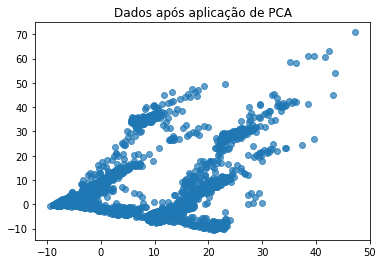

In [7]:
# redução de dimensionalidade
pca = PCA(n_components=2).fit(X)
X_2d = pca.transform(X)
# plot
plt.scatter(X_2d[:,0],X_2d[:,1],alpha=0.7)
plt.title("Dados após aplicação de PCA")
plt.show()

In [8]:
# treinamento com diferentes valores de K
k_values = range(2,12)
k_means_var = [KMeans(n_clusters=k).fit(X_2d) for k in k_values]
# calculo dos centros
centroids = [model.cluster_centers_ for model in k_means_var]

In [9]:
# méticas para escolha de melhor valor de K
# calculo da inércia
inertias = [model.inertia_ for model in k_means_var]
# Calculo do silhouette score
silhouettes = [silhouette_score(X_2d,model.labels_) for model in k_means_var]

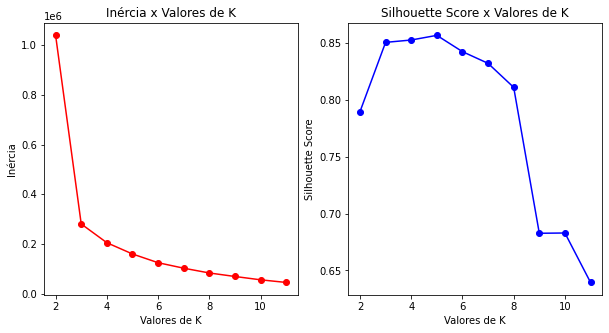

In [10]:
# plotagem da inércia e do silhouette score
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(k_values,inertias,"o-",color='r')
ax[0].set_title("Inércia x Valores de K")
ax[0].set_xlabel("Valores de K")
ax[0].set_ylabel("Inércia")

ax[1].plot(k_values,silhouettes,"o-",color='b')
ax[1].set_title("Silhouette Score x Valores de K")
ax[1].set_xlabel("Valores de K")
ax[1].set_ylabel("Silhouette Score")

plt.show()
# observando os graficos, o melhor silhouette score e inércia aceitável é K=5

In [15]:
# modelo final
modelo_final = KMeans(n_clusters=5).fit(X_2d)

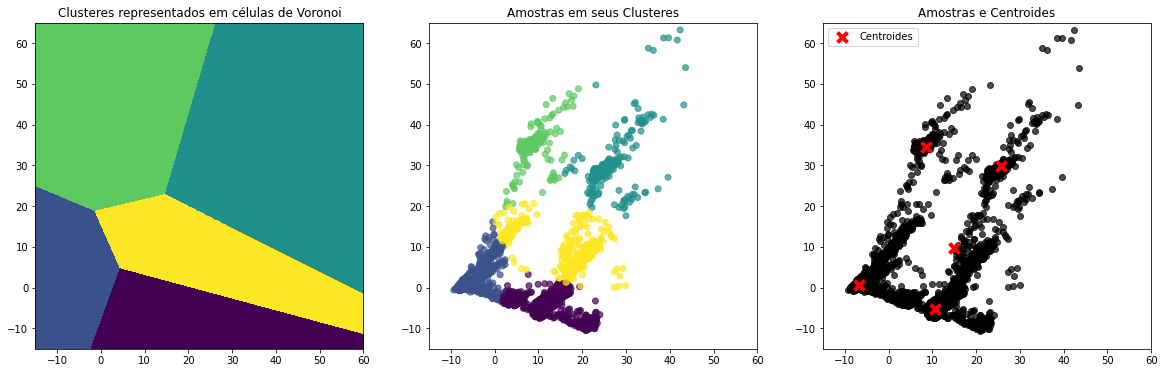

In [21]:
# plotagem
fig,ax = plt.subplots(1,3,figsize=(20,6))
# meshgrid
h = 0.02
xx, yy = np.meshgrid(np.arange(-15,60,h),np.arange(-15,65,h))
Z = modelo_final.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
ax[0].imshow(Z,
           interpolation="nearest",
           extent=(xx.min(),xx.max(),yy.min(),yy.max()),
           aspect="auto",
           origin="lower")
ax[0].set_xlim(-15,60)
ax[0].set_ylim(-15,65)
ax[0].set_title("Clusteres representados em células de Voronoi")

ax[1].scatter(X_2d[:,0],X_2d[:,1],c=modelo_final.labels_,alpha=0.7)
ax[1].set_xlim(-15,60)
ax[1].set_ylim(-15,65)
ax[1].set_title("Amostras em seus Clusteres")


ax[2].scatter(X_2d[:,0],X_2d[:,1],c='k',alpha=0.7)
ax[2].scatter(modelo_final.cluster_centers_[:,0],modelo_final.cluster_centers_[:,1],marker='x',color='r',label="Centroides",s=100,linewidths=4)
ax[2].set_xlim(-15,60)
ax[2].set_ylim(-15,65)
ax[2].legend()
ax[2].set_title("Amostras e Centroides")

plt.show()

In [17]:
# Silhouette Score do modelo final
silhouette = silhouette_score(X_2d,modelo_final.labels_)
print(f"Silhouette Score do modelo final: {round(silhouette,2)}")

Silhouette Score do modelo final: 0.86


In [18]:
# adicionando rótulos ao dataset
new_dataset["cluster"] = modelo_final.labels_
# média de consumo de energia por cluster
new_dataset[["Global_active_power","cluster"]].groupby(["cluster"]).mean().round(2)

,Global_active_power
cluster,
0,1.79
1,0.52
2,4.72
3,3.46
4,3.64
